## <b>GAN model for predicting AAPL price

### 1.) Import necessary libraries

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas_ta
import datetime as dt
import re
import pandas_datareader.data as web
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
import warnings
warnings.filterwarnings('ignore')

### 2.) Collecting data

In [3]:
ebay_fin = pd.read_csv('ebay_final.csv', index_col=0)
ebay_fin.head()

,Date,Close,eps_q,book_value,de_ratio,npm,gold,crudeoil,sp500,ndx,fed,rsi,MACD,SMA21,bbupper,bblower
0,2013-01-02,22.554714,0.020395,882.875297,0.028030,0.007753,163.169998,93.120003,1462.420044,2746.469971,0.17,0.000000,0.000000,22.712642,23.742261,21.598647
1,2013-01-03,22.074917,0.020838,902.064553,0.028639,0.007921,161.199997,92.919998,1459.369995,2732.260010,0.17,0.000000,-0.010765,22.712642,23.742261,21.598647
2,2013-01-04,22.213804,0.020708,896.424574,0.028460,0.007872,160.440002,93.089996,1466.469971,2724.489990,0.16,22.448816,-0.009409,22.712642,23.742261,21.598647
3,2013-01-07,22.521044,0.020425,884.195253,0.028072,0.007765,159.429993,93.190002,1461.890015,2724.219971,0.16,48.181794,0.002530,22.712642,23.742261,21.598647
4,2013-01-08,22.171717,0.020747,898.126215,0.028514,0.007887,160.559998,93.150002,1457.150024,2718.719971,0.15,34.983450,-0.004936,22.712642,23.742261,21.598647


### 3.) Data preprocessing

In [4]:
# 3.1) import libraries

import os
import pandas as pd
import numpy as np
import pandas as pd
import statsmodels.api as sm
from numpy import *
from math import sqrt
from pandas import *
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pickle import dump

ebay_fin['Date'] = pd.to_datetime(ebay_fin['Date'])
ebay_fin.set_index('Date', inplace=True)
display(ebay_fin.head())
display(ebay_fin.shape)

,Close,eps_q,book_value,de_ratio,npm,gold,crudeoil,sp500,ndx,fed,rsi,MACD,SMA21,bbupper,bblower
Date,,,,,,,,,,,,,,,
2013-01-02,22.554714,0.020395,882.875297,0.028030,0.007753,163.169998,93.120003,1462.420044,2746.469971,0.17,0.000000,0.000000,22.712642,23.742261,21.598647
2013-01-03,22.074917,0.020838,902.064553,0.028639,0.007921,161.199997,92.919998,1459.369995,2732.260010,0.17,0.000000,-0.010765,22.712642,23.742261,21.598647
2013-01-04,22.213804,0.020708,896.424574,0.028460,0.007872,160.440002,93.089996,1466.469971,2724.489990,0.16,22.448816,-0.009409,22.712642,23.742261,21.598647
2013-01-07,22.521044,0.020425,884.195253,0.028072,0.007765,159.429993,93.190002,1461.890015,2724.219971,0.16,48.181794,0.002530,22.712642,23.742261,21.598647
2013-01-08,22.171717,0.020747,898.126215,0.028514,0.007887,160.559998,93.150002,1457.150024,2718.719971,0.15,34.983450,-0.004936,22.712642,23.742261,21.598647


(2506, 15)

In [5]:
# 3.2) specifying x and y

X_value = pd.DataFrame(ebay_fin.iloc[:, :])
y_value = pd.DataFrame(ebay_fin.iloc[:, 0])

In [6]:
# 3.3) Normalized the data

X_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaler.fit(X_value)
y_scaler.fit(y_value)

X_scale_dataset = X_scaler.fit_transform(X_value)
y_scale_dataset = y_scaler.fit_transform(y_value)

dump(X_scaler, open('X_scaler.pkl', 'wb'))
dump(y_scaler, open('y_scaler.pkl', 'wb'))

In [7]:
display(X_scale_dataset.shape)
display(y_scale_dataset.shape)

(2506, 15)

(2506, 1)

In [8]:
# 3.4) function for reshaping data / getting index of training and testing
# and spliting train and test dataset

n_steps_in = 3
n_features = X_value.shape[1]
n_steps_out = 1

# Get X/y dataset
def get_X_y(X_data, y_data):
    X = list()
    y = list()
    yc = list()

    length = len(X_data)
    for i in range(0, length, 1):
        X_value = X_data[i: i + n_steps_in][:, :]
        y_value = y_data[i + n_steps_in: i + (n_steps_in + n_steps_out)][:, 0]
        yc_value = y_data[i: i + n_steps_in][:, :]
        if len(X_value) == 3 and len(y_value) == 1:
            X.append(X_value)
            y.append(y_value)
            yc.append(yc_value)

    return np.array(X), np.array(y), np.array(yc)

# get the train test predict index
def predict_index(dataset, X_train, n_steps_in, n_steps_out):

    # get the predict data (remove the in_steps days)
    train_predict_index = dataset.iloc[n_steps_in : X_train.shape[0] + n_steps_in + n_steps_out - 1, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + n_steps_in:, :].index

    return train_predict_index, test_predict_index

# Split train/test dataset
def split_train_test(data):
    train_size = round(len(X) * 0.7)
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [11]:
# 3.5) getting data and checking for shape

X, y, yc = get_X_y(X_scale_dataset, y_scale_dataset)
X_train, X_test, = split_train_test(X)
y_train, y_test, = split_train_test(y)
yc_train, yc_test, = split_train_test(yc)
index_train, index_test, = predict_index(ebay_fin, X_train, n_steps_in, n_steps_out)

In [12]:
# 3.6) show data's shape and save

print('X shape: ', X.shape)
print('y shape: ', y.shape)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('y_c_train shape: ', yc_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)
print('y_c_test shape: ', yc_test.shape)
print('index_train shape:', index_train.shape)
print('index_test shape:', index_test.shape)

np.save("X_train.npy", X_train)
np.save("y_train.npy", y_train)
np.save("X_test.npy", X_test)
np.save("y_test.npy", y_test)
np.save("yc_train.npy", yc_train)
np.save("yc_test.npy", yc_test)
np.save('index_train.npy', index_train)
np.save('index_test.npy', index_test)

X shape:  (2503, 3, 15)
y shape:  (2503, 1)
X_train shape:  (1752, 3, 15)
y_train shape:  (1752, 1)
y_c_train shape:  (1752, 3, 1)
X_test shape:  (751, 3, 15)
y_test shape:  (751, 1)
y_c_test shape:  (751, 3, 1)
index_train shape: (1752,)
index_test shape: (751,)


### 4.) GAN framework - training model

In [13]:
# 4.1) import libraries

import time
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
#from main.feature import get_all_features
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from pickle import load
from sklearn.metrics import mean_squared_error

In [14]:
# 4.2) import data

X_train = np.load("X_train.npy", allow_pickle=True)
y_train = np.load("y_train.npy", allow_pickle=True)
X_test = np.load("X_test.npy", allow_pickle=True)
y_test = np.load("y_test.npy", allow_pickle=True)
yc_train = np.load("yc_train.npy", allow_pickle=True)
yc_test = np.load("yc_test.npy", allow_pickle=True)

In [15]:
# 4.3) function for generator, discriminator and GAN

def make_generator_model(input_dim, output_dim, feature_size) -> tf.keras.models.Model:

    model = Sequential()
    model.add(GRU(units=1024, return_sequences = True, input_shape=(input_dim, feature_size),
                  recurrent_dropout=0.2))
    model.add(GRU(units=512, return_sequences = True, recurrent_dropout=0.2)) # 256, return_sequences = True
    model.add(GRU(units=256, recurrent_dropout=0.2)) #, recurrent_dropout=0.1
    # , recurrent_dropout = 0.2
    model.add(Dense(128))
    # model.add(Dense(128))
    model.add(Dense(64))
    #model.add(Dense(16))
    model.add(Dense(units=output_dim))
    return model

def make_discriminator_model():

    cnn_net = tf.keras.Sequential()
    cnn_net.add(Conv1D(32, input_shape=(4, 1), kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(64, kernel_size=5, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(128, kernel_size=5, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Flatten())
    cnn_net.add(Dense(220, use_bias=False))
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False, activation='relu'))
    cnn_net.add(Dense(1, activation='sigmoid'))
    return cnn_net

class GAN:
    def __init__(self, generator, discriminator, opt):
        self.opt = opt
        self.lr = opt["lr"]
        self.generator = generator
        self.discriminator = discriminator
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.generator_optimizer = tf.keras.optimizers.Adam(lr=self.lr)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(lr=self.lr)
        self.batch_size = self.opt['bs']
        self.checkpoint_dir = '../training_checkpoints'
        self.checkpoint_prefix = os.path.join(self.checkpoint_dir, "ckpt")
        self.checkpoint = tf.train.Checkpoint(generator_optimizer=self.generator_optimizer,
                                              discriminator_optimizer=self.discriminator_optimizer,
                                              generator=self.generator,
                                              discriminator=self.discriminator)

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    @tf.function
    def train_step(self, real_x, real_y, yc):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_data = self.generator(real_x, training=True)
            generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
            d_fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), yc], axis=1)
            real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
            d_real_input = tf.concat([real_y_reshape, yc], axis=1)

            # Reshape for MLP
            # d_fake_input = tf.reshape(d_fake_input, [d_fake_input.shape[0], d_fake_input.shape[1]])
            # d_real_input = tf.reshape(d_real_input, [d_real_input.shape[0], d_real_input.shape[1]])

            real_output = self.discriminator(d_real_input, training=True)
            fake_output = self.discriminator(d_fake_input, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(
            zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        return real_y, generated_data, {'d_loss': disc_loss, 'g_loss': gen_loss}

    def train(self, real_x, real_y, yc, opt):
        train_hist = {}
        train_hist['D_losses'] = []
        train_hist['G_losses'] = []
        train_hist['per_epoch_times'] = []
        train_hist['total_ptime'] = []

        epochs = opt["epoch"]
        for epoch in range(epochs):
            start = time.time()

            real_price, fake_price, loss = self.train_step(real_x, real_y, yc)

            G_losses = []
            D_losses = []

            Real_price = []
            Predicted_price = []

            D_losses.append(loss['d_loss'].numpy())
            G_losses.append(loss['g_loss'].numpy())

            Predicted_price.append(fake_price.numpy())
            Real_price.append(real_price.numpy())

            # Save the model every 15 epochs
            if (epoch + 1) % 15 == 0:
                tf.keras.models.save_model(generator, 'gen_model_3_1_%d.h5' % epoch)
                self.checkpoint.save(file_prefix=self.checkpoint_prefix + f'-{epoch}')
                print('epoch', epoch + 1, 'd_loss', loss['d_loss'].numpy(), 'g_loss', loss['g_loss'].numpy())
            # print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))
            # For printing loss
            epoch_end_time = time.time()
            per_epoch_ptime = epoch_end_time - start
            train_hist['D_losses'].append(D_losses)
            train_hist['G_losses'].append(G_losses)
            train_hist['per_epoch_times'].append(per_epoch_ptime)

        # Reshape the predicted result & real
        Predicted_price = np.array(Predicted_price)
        Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
        Real_price = np.array(Real_price)
        Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

        plt.plot(train_hist['D_losses'], label='D_loss')
        plt.plot(train_hist['G_losses'], label='G_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(
            Real_price)

epoch 15 d_loss 1.3874307 g_loss 0.67823666


epoch 30 d_loss 1.3843503 g_loss 0.70479316


epoch 45 d_loss 1.3840106 g_loss 0.69626963


epoch 60 d_loss 1.3857796 g_loss 0.69540155


epoch 75 d_loss 1.3864323 g_loss 0.6937156


epoch 90 d_loss 1.3854873 g_loss 0.6908437


epoch 105 d_loss 1.3728172 g_loss 0.6994814


epoch 120 d_loss 1.3689451 g_loss 0.7100079


epoch 135 d_loss 1.3331163 g_loss 0.6663703


epoch 150 d_loss 1.204572 g_loss 0.88591117


epoch 165 d_loss 1.3512522 g_loss 0.6265517


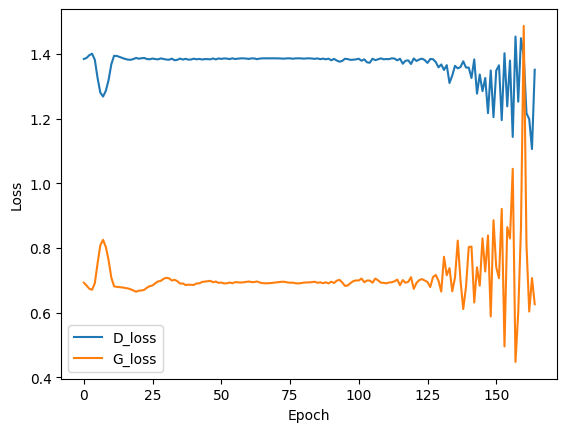

In [16]:
# 4.4) training model

input_dim = X_train.shape[1]
feature_size = X_train.shape[2]
output_dim = y_train.shape[1]

## For Bayesian
opt = {"lr": 0.00008, "epoch": 165, 'bs': 64}

generator = make_generator_model(X_train.shape[1], output_dim, X_train.shape[2])
discriminator = make_discriminator_model()
gan = GAN(generator, discriminator, opt)
Predicted_price, Real_price, RMSPE = gan.train(X_train, y_train, yc_train, opt)

### 6.) GAN framework - checking RSME for training set

In [17]:
RMSE_training = {}

models = [
    'gen_model_3_1_14.h5',
    'gen_model_3_1_29.h5',
    'gen_model_3_1_44.h5',
    'gen_model_3_1_59.h5',
    'gen_model_3_1_74.h5',
    'gen_model_3_1_89.h5',
    'gen_model_3_1_104.h5',
    'gen_model_3_1_119.h5',
    'gen_model_3_1_134.h5',
    'gen_model_3_1_149.h5',
    'gen_model_3_1_164.h5'
]



def get_test_plot(X_test, y_test):
    # Set output steps
    output_dim = y_test.shape[1]

    # Get predicted data
    y_predicted = G_model(X_test)
    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(y_predicted)

    ## Predicted price
    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=train_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    ## Real price
    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"], index=train_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    #drop 2020
    # Input_Before = '2020-01-01'
    # predict_result = predict_result.loc[predict_result.index < Input_Before]
    # real_price = real_price.loc[real_price.index < Input_Before]

    # Plot the predicted result
    # plt.figure(figsize=(16, 8))
    # plt.plot(real_price["real_mean"])
    # plt.plot(predict_result["predicted_mean"], color='r')
    # plt.xlabel("Date")
    # plt.ylabel("Stock price")
    # plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    # plt.title("The result of test", fontsize=20)
    # plt.show()
    # plt.savefig('test_plot.png')

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis=1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('-- RMSE -- ', RMSE)

    return predict_result, RMSE

# Load test dataset/ 

for model in models:
    X_scaler = load(open('X_scaler.pkl', 'rb'))
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    train_predict_index = np.load("index_train.npy", allow_pickle=True)
    test_predict_index = np.load("index_test.npy", allow_pickle=True)
    G_model = tf.keras.models.load_model(model)
    X_test = np.load("X_train.npy", allow_pickle=True)
    y_test = np.load("y_train.npy", allow_pickle=True)
    test_predicted, test_RMSE = get_test_plot(X_test, y_test)
    RMSE_training[model] = test_RMSE

print(RMSE_training)

-- RMSE --  30.55435615136035


-- RMSE --  8.594125479687046


-- RMSE --  2.046040551606793


-- RMSE --  1.4574793234565806


-- RMSE --  0.845824541183052


-- RMSE --  3.204828866944861


-- RMSE --  1.0788415788544716


-- RMSE --  1.006946997574816


-- RMSE --  1.876590963223112


-- RMSE --  1.335839757927046


-- RMSE --  7.779829541725047
{'gen_model_3_1_14.h5': 30.55435615136035, 'gen_model_3_1_29.h5': 8.594125479687046, 'gen_model_3_1_44.h5': 2.046040551606793, 'gen_model_3_1_59.h5': 1.4574793234565806, 'gen_model_3_1_74.h5': 0.845824541183052, 'gen_model_3_1_89.h5': 3.204828866944861, 'gen_model_3_1_104.h5': 1.0788415788544716, 'gen_model_3_1_119.h5': 1.006946997574816, 'gen_model_3_1_134.h5': 1.876590963223112, 'gen_model_3_1_149.h5': 1.335839757927046, 'gen_model_3_1_164.h5': 7.779829541725047}


### 5.) GAN framework - checking RMSE for testing set

In [18]:
RMSE_testing = {}

models = [
    'gen_model_3_1_14.h5',
    'gen_model_3_1_29.h5',
    'gen_model_3_1_44.h5',
    'gen_model_3_1_59.h5',
    'gen_model_3_1_74.h5',
    'gen_model_3_1_89.h5',
    'gen_model_3_1_104.h5',
    'gen_model_3_1_119.h5',
    'gen_model_3_1_134.h5',
    'gen_model_3_1_149.h5',
    'gen_model_3_1_164.h5'
]

def get_test_plot(X_test, y_test):
    # Set output steps
    output_dim = y_test.shape[1]

    # Get predicted data
    y_predicted = G_model(X_test)
    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(y_predicted)

    ## Predicted price
    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=test_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    ## Real price
    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"], index=test_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    #drop 2020
    # Input_Before = '2020-01-01'
    # predict_result = predict_result.loc[predict_result.index < Input_Before]
    # real_price = real_price.loc[real_price.index < Input_Before]

    # Plot the predicted result
    # plt.figure(figsize=(16, 8))
    # plt.plot(real_price["real_mean"])
    # plt.plot(predict_result["predicted_mean"], color='r')
    # plt.xlabel("Date")
    # plt.ylabel("Stock price")
    # plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    # plt.title("The result of test", fontsize=20)
    # plt.show()
    # plt.savefig('test_plot.png')
    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis=1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('-- RMSE -- ', RMSE)

    return predict_result, RMSE


# Load scaler/ index
for model in models:
    X_scaler = load(open('X_scaler.pkl', 'rb'))
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    train_predict_index = np.load("index_train.npy", allow_pickle=True)
    test_predict_index = np.load("index_test.npy", allow_pickle=True)
    G_model = tf.keras.models.load_model(model)
    X_test = np.load("X_test.npy", allow_pickle=True)
    y_test = np.load("y_test.npy", allow_pickle=True)
    test_predicted, test_RMSE = get_test_plot(X_test, y_test)
    # test_predicted.to_csv("test_predicted.csv")
    RMSE_testing[model] = test_RMSE

-- RMSE --  15.20489228077503


-- RMSE --  5.81104845935332


-- RMSE --  3.3235123155777972


-- RMSE --  4.032751637558985


-- RMSE --  4.883763181102757


-- RMSE --  4.908641086710941


-- RMSE --  3.198271998300211


-- RMSE --  5.177284341384073


-- RMSE --  3.9867951561712465


-- RMSE --  3.504385426795487


-- RMSE --  14.932844842572733


### 6.) Comparing Result and select the right model

In [19]:
RMSE_data = {'Training' : pd.Series(RMSE_training).values, 'Testing' : pd.Series(RMSE_testing).values}
RMSE_index = pd.Series(RMSE_testing).index
RMSE_all_model = pd.DataFrame(RMSE_data, RMSE_index)
display(RMSE_all_model)

,Training,Testing
gen_model_3_1_14.h5,30.554356,15.204892
gen_model_3_1_29.h5,8.594125,5.811048
gen_model_3_1_44.h5,2.046041,3.323512
gen_model_3_1_59.h5,1.457479,4.032752
gen_model_3_1_74.h5,0.845825,4.883763
gen_model_3_1_89.h5,3.204829,4.908641
gen_model_3_1_104.h5,1.078842,3.198272
gen_model_3_1_119.h5,1.006947,5.177284
gen_model_3_1_134.h5,1.876591,3.986795
gen_model_3_1_149.h5,1.335840,3.504385


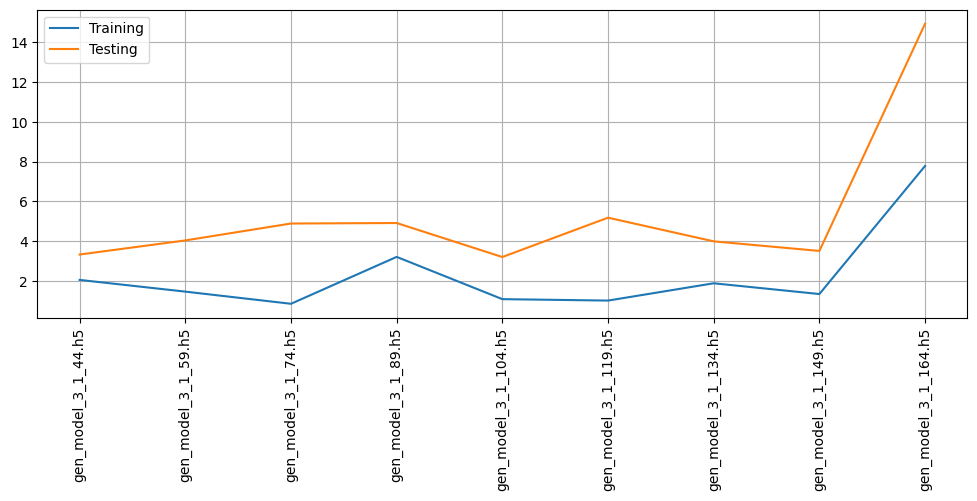

In [20]:
RMSE_all_model[['Training','Testing']].iloc[2:,:].plot(figsize = (12,4))
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

### 7.) Visualize training set of model having epoch = 120

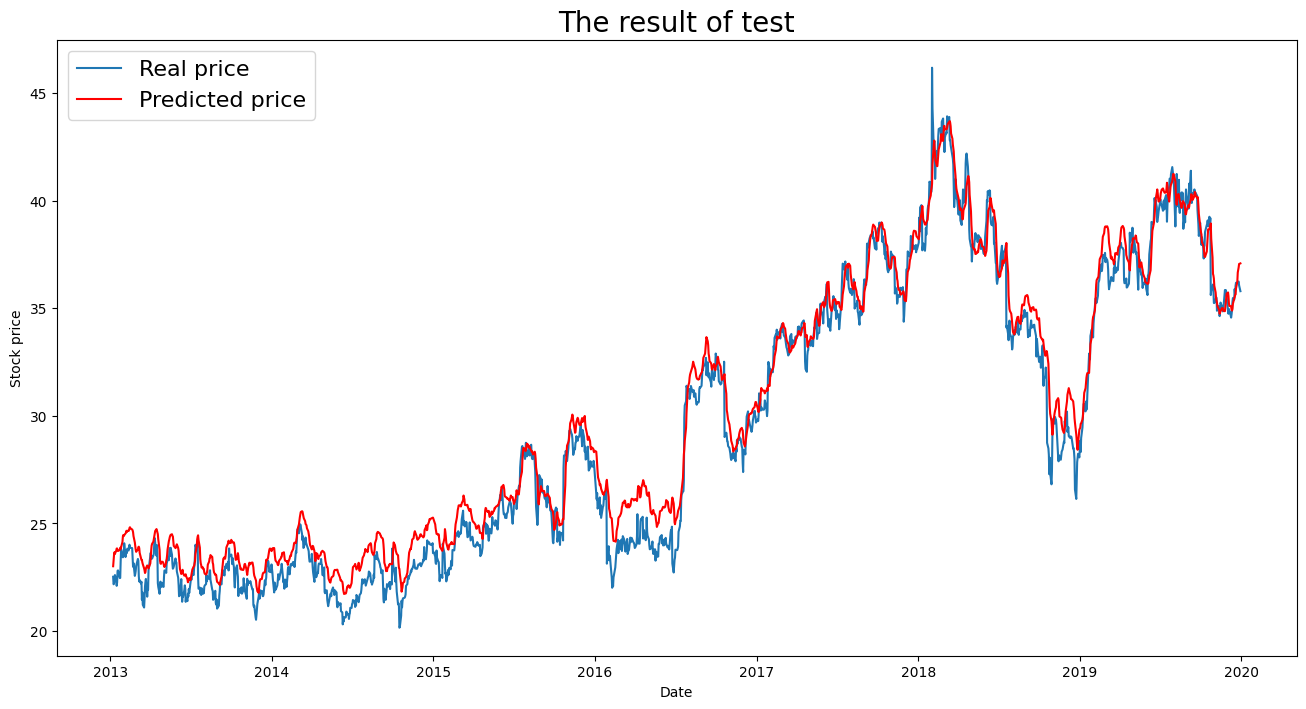

-- RMSE --  1.0788415788544716
-- MAE -- 0.8727528820613363
-- MAPE -- 0.03272120086219844
-- MSLE -- 0.001521733846280329
--R2 -- 0.9729927124768674


<Figure size 640x480 with 0 Axes>

In [21]:
import time
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
#from main.feature import get_all_features
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from pickle import load
from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_absolute_error, mean_squared_log_error, r2_score, mean_absolute_percentage_error

# def mean_absolute_percentage_error(actual, predicted):
#     actual, predicted = np.array(actual), np.array(predicted)
#     nonzero_elements = actual != 0
#     mape = np.mean(np.abs((actual - predicted) / actual[nonzero_elements])) * 100
#     return mape

# Load scaler/ index
X_scaler = load(open('X_scaler.pkl', 'rb'))
y_scaler = load(open('y_scaler.pkl', 'rb'))
train_predict_index = np.load("index_train.npy", allow_pickle=True)
test_predict_index = np.load("index_test.npy", allow_pickle=True)

# Load test dataset/ model
G_model = tf.keras.models.load_model('gen_model_3_1_104.h5')
X_test = np.load("X_train.npy", allow_pickle=True)
y_test = np.load("y_train.npy", allow_pickle=True)


def get_test_plot(X_test, y_test):
    # Set output steps
    output_dim = y_test.shape[1]

    # Get predicted data
    y_predicted = G_model(X_test)
    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(y_predicted)

    ## Predicted price
    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=train_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    ## Real price
    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"], index=train_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    #drop 2020
    # Input_Before = '2020-01-01'
    # predict_result = predict_result.loc[predict_result.index < Input_Before]
    # real_price = real_price.loc[real_price.index < Input_Before]

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of test", fontsize=20)
    plt.show()
    plt.savefig('test_plot.png')
    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis=1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    MAE = mean_absolute_error(real, predicted)
    MAPE = mean_absolute_percentage_error(real, predicted)
    MSLE = mean_squared_log_error(real, predicted)
    r2 = r2_score(real, predicted)
    print('-- RMSE -- ', RMSE)
    print('-- MAE --', MAE)
    print('-- MAPE --', MAPE)
    print('-- MSLE --', MSLE)
    print('--R2 --', r2)
    return predict_result, RMSE


train_predicted, test_RMSE = get_test_plot(X_test, y_test)

### 8.) Visualize testing set of model having epoch = 120

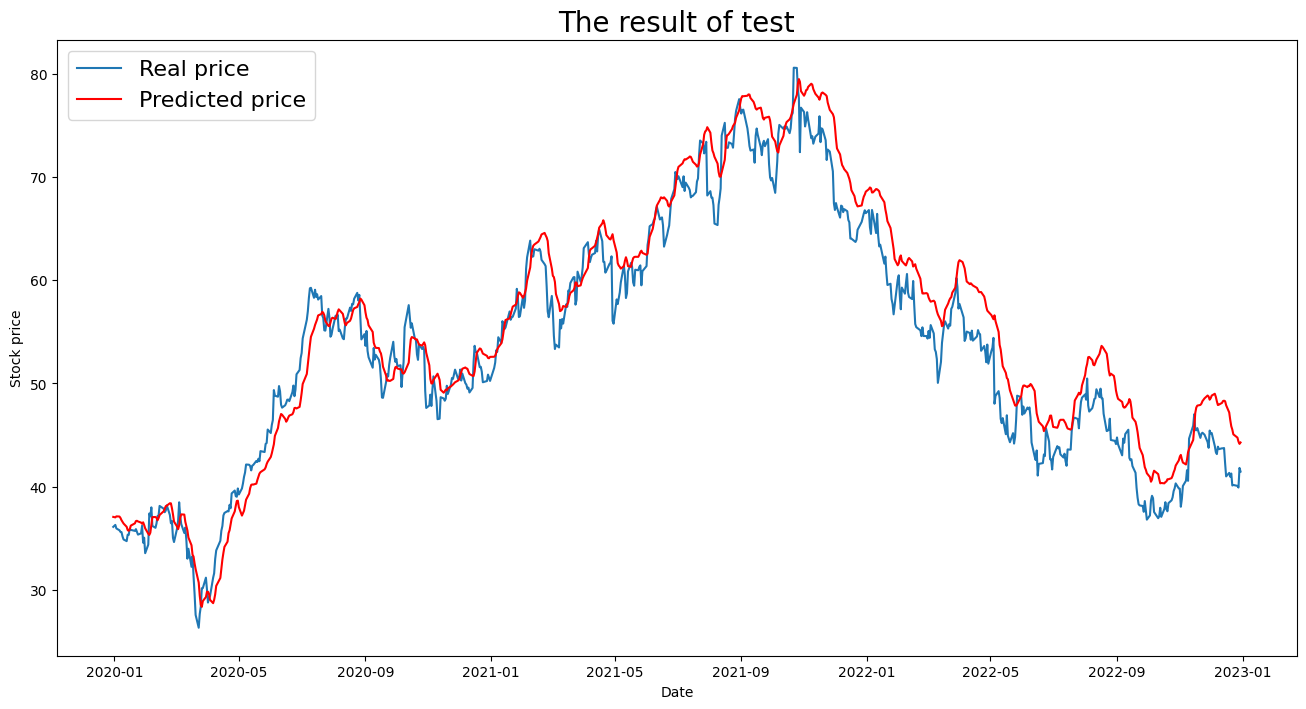

-- RMSE --  3.198271998300211
-- MAE -- 2.6294748533962737
-- MAPE -- 0.05173887707727122
-- MSLE -- 0.003642707436596278
--R2 -- 0.9266654983978955


<Figure size 640x480 with 0 Axes>

In [22]:
# Load scaler/ index
from sklearn.metrics import mean_absolute_error, mean_squared_log_error, r2_score, mean_absolute_percentage_error

# def mean_absolute_percentage_error(actual, predicted):
#     actual, predicted = np.array(actual), np.array(predicted)
#     nonzero_elements = actual != 0
#     mape = np.mean(np.abs((actual - predicted) / actual[nonzero_elements])) * 100
#     return mape

X_scaler = load(open('X_scaler.pkl', 'rb'))
y_scaler = load(open('y_scaler.pkl', 'rb'))
train_predict_index = np.load("index_train.npy", allow_pickle=True)
test_predict_index = np.load("index_test.npy", allow_pickle=True)

# Load test dataset/ model
G_model = tf.keras.models.load_model('gen_model_3_1_104.h5')
X_test = np.load("X_test.npy", allow_pickle=True)
y_test = np.load("y_test.npy", allow_pickle=True)


def get_test_plot(X_test, y_test):
    # Set output steps
    output_dim = y_test.shape[1]

    # Get predicted data
    y_predicted = G_model(X_test)
    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(y_predicted)

    ## Predicted price
    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=test_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    ## Real price
    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"], index=test_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    #drop 2020
    # Input_Before = '2020-01-01'
    # predict_result = predict_result.loc[predict_result.index < Input_Before]
    # real_price = real_price.loc[real_price.index < Input_Before]

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of test", fontsize=20)
    plt.show()
    plt.savefig('test_plot.png')
    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis=1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    MAE = mean_absolute_error(real, predicted)
    MAPE = mean_absolute_percentage_error(real, predicted)
    MSLE = mean_squared_log_error(real, predicted)
    r2 = r2_score(real, predicted)
    print('-- RMSE -- ', RMSE)
    print('-- MAE --', MAE)
    print('-- MAPE --', MAPE)
    print('-- MSLE --', MSLE)
    print('--R2 --', r2)

    return predict_result, RMSE


test_predicted, test_RMSE = get_test_plot(X_test, y_test)
test_predicted.to_csv("test_predicted_final.csv")

### 9.) Constructing Trading Strategy

In [ ]:
# 9.1) create the training set's predicted price dataframe

train_predicted_price = pd.DataFrame(train_predicted.iloc[:,-1])
train_predicted_price.rename(columns={'predicted_mean':'predicted_price'},inplace=True)
display(train_predicted_price.head(3))
display(train_predicted_price.tail(3))

In [28]:
# 9.2) create the testing set's predicted price dataframe

test_predicted_price = pd.DataFrame(test_predicted.iloc[:,-1])
test_predicted_price.rename(columns={'predicted_mean':'predicted_price'},inplace=True)
display(test_predicted_price.head(3))
display(test_predicted_price.tail(3))

,predicted_price
2019-12-31,71.872503
2020-01-02,72.421694
2020-01-03,73.154931


,predicted_price
2022-12-28,120.143100
2022-12-29,118.497785
2022-12-30,116.995155


In [29]:
# 9.3 create dataframe for constructing strategy

training_strategy = pd.DataFrame(apple_fin['Close'].filter(items = index_train, axis = 0))
print('for training :')
training_strategy['predicted_price'] = train_predicted_price.values
display(training_strategy.head(3))
display(training_strategy.tail(3))

testing_strategy = pd.DataFrame(apple_fin['Close'].filter(items = index_test, axis = 0))
print('for testing :')
testing_strategy['predicted_price'] = test_predicted_price.values
display(testing_strategy.head(3))
display(testing_strategy.tail(3))

for training :


,Close,predicted_price
Date,,
2013-01-07,18.710714,13.291497
2013-01-08,18.761070,12.982764
2013-01-09,18.467857,12.668661


,Close,predicted_price
Date,,
2019-12-26,72.477501,70.329427
2019-12-27,72.449997,70.973698
2019-12-30,72.879997,71.495812


for testing :


,Close,predicted_price
Date,,
2019-12-31,73.412498,71.872503
2020-01-02,75.087502,72.421694
2020-01-03,74.357498,73.154931


,Close,predicted_price
Date,,
2022-12-28,126.040001,120.143100
2022-12-29,129.610001,118.497785
2022-12-30,129.929993,116.995155


In [30]:
# 9.4 calculate normal return and log return of SBUX

def calculate_returns(df):
    df['normal_return'] = df['Close'].pct_change()
    df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
    df['cumulative_return'] = df[['log_return']].cumsum().apply(np.exp)
    return df

training_strategy = calculate_returns(training_strategy)
testing_strategy = calculate_returns(testing_strategy)


In [31]:
# 9.5 display the final dataframes

display(training_strategy.head())
display(testing_strategy.head())

,Close,predicted_price,normal_return,log_return,cumulative_return
Date,,,,,
2013-01-07,18.710714,13.291497,NaN,NaN,NaN
2013-01-08,18.761070,12.982764,0.002691,0.002688,1.002691
2013-01-09,18.467857,12.668661,-0.015629,-0.015752,0.987020
2013-01-10,18.696787,12.643598,0.012396,0.012320,0.999256
2013-01-11,18.582144,12.515787,-0.006132,-0.006151,0.993129


,Close,predicted_price,normal_return,log_return,cumulative_return
Date,,,,,
2019-12-31,73.412498,71.872503,NaN,NaN,NaN
2020-01-02,75.087502,72.421694,0.022816,0.022560,1.022816
2020-01-03,74.357498,73.154931,-0.009722,-0.009770,1.012872
2020-01-06,74.949997,73.918297,0.007968,0.007937,1.020943
2020-01-07,74.597504,74.321499,-0.004703,-0.004714,1.016142


> <b>9.6) Naive condition</b>\
> Long : The predicted price is higher than the closing price of today\
> Short : The predicted price is lower than the closing price of today

In [32]:
# 9.6.1 create function for strategy return

def naive_strategy(df):
    df['position'] = np.nan
    df['position'] = np.where(df['predicted_price'] > df['Close'], 1, -1)
    df['strategy_return'] = df['position'].shift(1) * df['log_return']
    df['cumulative_strategy_return'] = df['strategy_return'].cumsum().apply(np.exp)
    return df

training_strategy = naive_strategy(training_strategy)
testing_strategy = naive_strategy(testing_strategy)

print('for training :')
display(training_strategy.tail())

print('for testing :')
display(testing_strategy.tail())

for training :


,Close,predicted_price,normal_return,log_return,cumulative_return,position,strategy_return,cumulative_strategy_return
Date,,,,,,,,
2019-12-23,71.000000,69.184351,0.016318,0.016187,3.794617,-1,-0.016187,0.908043
2019-12-24,71.067497,69.574801,0.000951,0.000950,3.798225,-1,-0.000950,0.907181
2019-12-26,72.477501,70.329427,0.019840,0.019646,3.873583,-1,-0.019646,0.889532
2019-12-27,72.449997,70.973698,-0.000379,-0.000380,3.872113,-1,0.000380,0.889870
2019-12-30,72.879997,71.495812,0.005935,0.005918,3.895094,-1,-0.005918,0.884620


for testing :


,Close,predicted_price,normal_return,log_return,cumulative_return,position,strategy_return,cumulative_strategy_return
Date,,,,,,,,
2022-12-23,131.860001,123.000629,-0.002798,-0.002802,1.796152,-1,0.002802,1.347768
2022-12-27,130.029999,121.810257,-0.013878,-0.013976,1.771224,-1,0.013976,1.366736
2022-12-28,126.040001,120.143100,-0.030685,-0.031166,1.716874,-1,0.031166,1.410002
2022-12-29,129.610001,118.497785,0.028324,0.027931,1.765503,-1,-0.027931,1.371165
2022-12-30,129.929993,116.995155,0.002469,0.002466,1.769862,-1,-0.002466,1.367788


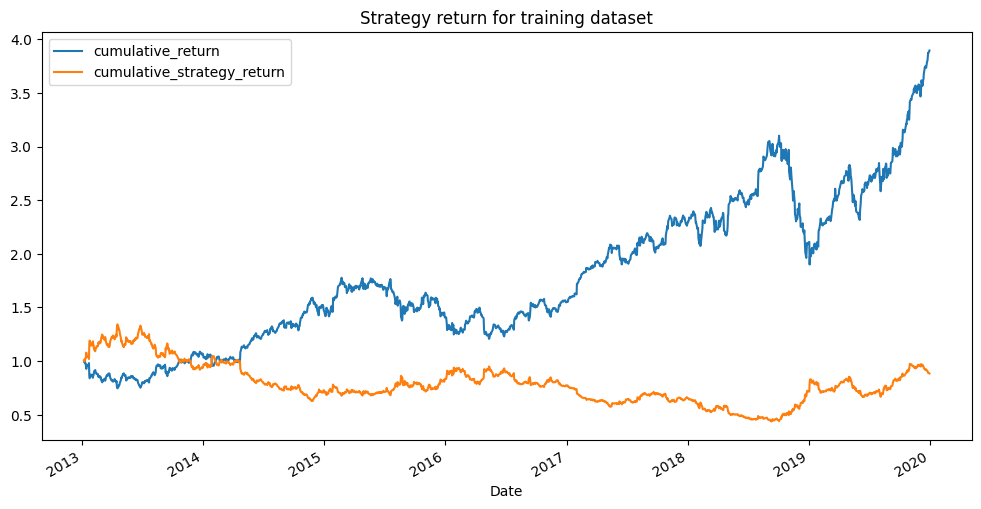

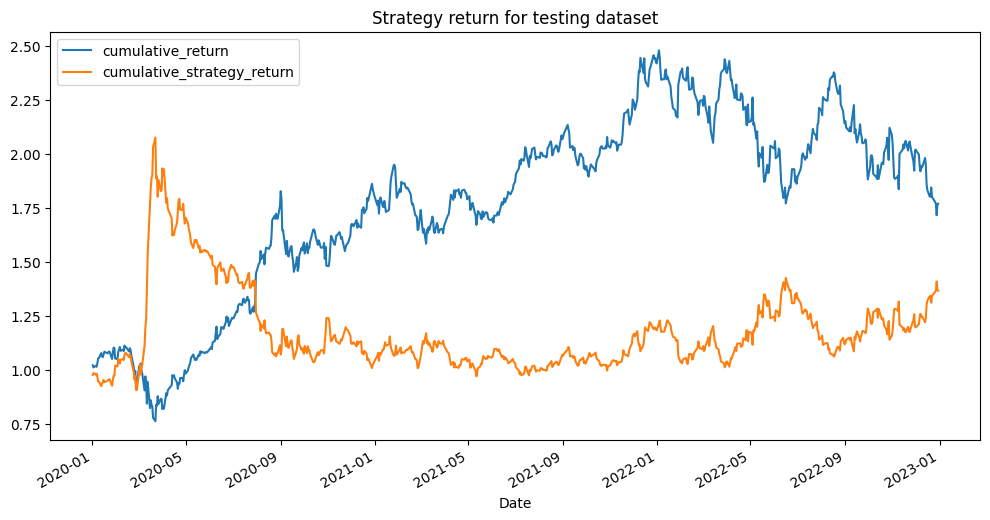

In [33]:
# 9.6.2) visualize the result

training_strategy[['cumulative_return','cumulative_strategy_return']].plot(figsize = (12,6))
plt.title('Strategy return for training dataset')
plt.show()
testing_strategy[['cumulative_return','cumulative_strategy_return']].plot(figsize = (12,6))
plt.title('Strategy return for testing dataset')
plt.show()

In [34]:
# 9.6.3) calculate CAGR (Compound annual growth rate)

days = (apple_fin.index[-1] - apple_fin.index[0]).days
cagr_BH_train = (((training_strategy['cumulative_return'][-1]/ training_strategy['cumulative_return'][1]))**(365 / days))-1
cagr_ML_train = (((training_strategy['cumulative_strategy_return'][-1]/ training_strategy['cumulative_strategy_return'][1]))**(365 / days))-1
cagr_BH_test = (((testing_strategy['cumulative_return'][-1]/ testing_strategy['cumulative_return'][1]))**(365 / days))-1
cagr_ML_test = (((testing_strategy['cumulative_strategy_return'][-1]/ testing_strategy['cumulative_strategy_return'][1]))**(365 / days))-1

print('For training set :')
print('CAGR of buy and hold from 2013 to end of 2019 is {:.5f}'.format(cagr_BH_train))
print('CAGR of our strategy from 2013 to end of 2019 is {:.5f}'.format(cagr_ML_train))
print(' ')
print('For testing set :')
print('CAGR of buy and hold from 2020 to end of 2022 is {:.5f}'.format(cagr_BH_test))
print('CAGR of our strategy from 2020 to end of 2022 is {:.5f}'.format(cagr_ML_test))

For training set :
CAGR of buy and hold from 2013 to end of 2019 is 0.14538
CAGR of our strategy from 2013 to end of 2019 is -0.01192
 
For testing set :
CAGR of buy and hold from 2020 to end of 2022 is 0.05638
CAGR of our strategy from 2020 to end of 2022 is 0.03415
